# Import modules

In [1]:
import tensorflow as tf
import os
import cv2
import numpy as np
from tensorflow.keras import backend, optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GaussianNoise, Dense
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

import matplotlib.pyplot as plt
%matplotlib inline

from vit_keras import vit

# Prepare generators

Found 3041 images belonging to 20 classes.
Found 100 images belonging to 20 classes.
Found 100 images belonging to 20 classes.


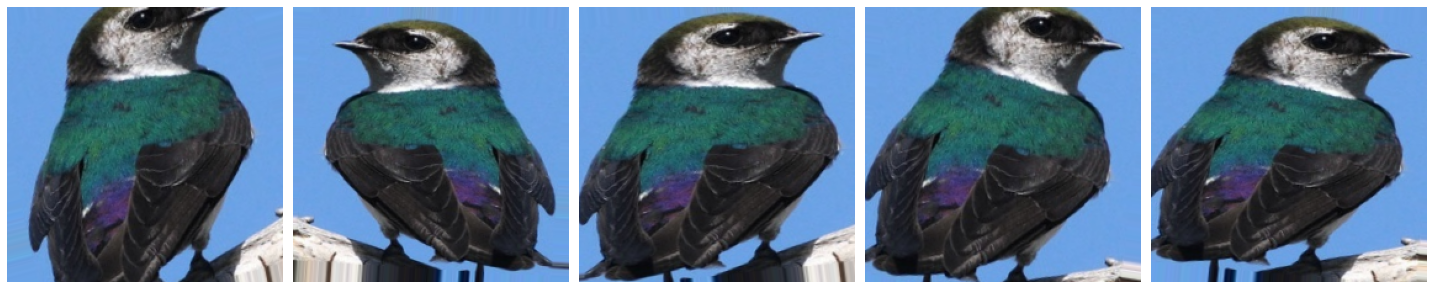

In [2]:
train_path = './dataset/20train'
test_path = './dataset/20test'
valid_path = './dataset/20valid'

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1,
)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='sparse',
    # shuffle=True,
)

validation_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='sparse')

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='sparse')


def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Load pre-trained ViT Model

In [3]:
backend.clear_session()

vit_model = vit.vit_l32(
    image_size=224,
    pretrained=True,
    include_top=False,
    pretrained_top=False
)

print(len(vit_model.layers))
print(vit_model.layers)

2022-05-06 18:06:07.335605: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-06 18:06:07.335699: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



/Users/shaun/miniforge3/lib/python3.9/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


31
[<keras.engine.input_layer.InputLayer object at 0x1064a4dc0>, <keras.layers.convolutional.Conv2D object at 0x16b7b2ca0>, <keras.layers.core.reshape.Reshape object at 0x16b803340>, <vit_keras.layers.ClassToken object at 0x16b803a60>, <vit_keras.layers.AddPositionEmbs object at 0x16ba9ae80>, <vit_keras.layers.TransformerBlock object at 0x16bac49a0>, <vit_keras.layers.TransformerBlock object at 0x16bacafa0>, <vit_keras.layers.TransformerBlock object at 0x16bcca250>, <vit_keras.layers.TransformerBlock object at 0x16c19cd00>, <vit_keras.layers.TransformerBlock object at 0x16c1eda90>, <vit_keras.layers.TransformerBlock object at 0x2a0d348e0>, <vit_keras.layers.TransformerBlock object at 0x177fdd2b0>, <vit_keras.layers.TransformerBlock object at 0x2b8a0dca0>, <vit_keras.layers.TransformerBlock object at 0x2b8a15280>, <vit_keras.layers.TransformerBlock object at 0x2c1089e80>, <vit_keras.layers.TransformerBlock object at 0x2c420e820>, <vit_keras.layers.TransformerBlock object at 0x2c42249d0>

# Learning Scheduler

In [4]:
# Decay lr for each 7 epochs
def scheduler(epoch: int, lr: float) -> float:
    if epoch != 0 and epoch % 7 == 0:
        return lr * 0.1
    else:
        return lr
lr_scheduler_callback = LearningRateScheduler(scheduler)

# Build model and train model

In [5]:
finetune_at = 28

# fine-tuning
for layer in vit_model.layers[:finetune_at - 1]:
    layer.trainable = False
    
num_classes = len(validation_generator.class_indices)

# Add GaussianNoise layer for robustness
noise = GaussianNoise(0.01, input_shape=(224, 224, 3))
# Classification head
head = Dense(num_classes, activation="softmax")

model = Sequential()
model.add(noise)
model.add(vit_model)
model.add(head)

model.compile(optimizer=optimizers.Adam(),loss="sparse_categorical_crossentropy",metrics=["accuracy"])
                      
history = model.fit(
          train_generator,
          epochs=100,
          validation_data=validation_generator,
          verbose=1, 
          # shuffle=True,
          callbacks=[
              EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True),
              lr_scheduler_callback,
          ])

Epoch 1/100


2022-05-06 18:06:13.425853: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-06 18:06:22.488282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - ETA: 0s - loss: 0.2173 - accuracy: 0.9398

2022-05-06 18:09:53.640921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 233s 2s/step - loss: 0.2173 - accuracy: 0.9398 - val_loss: 0.0219 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 2/100
96/96 [==============================] - 297s 3s/step - loss: 0.0432 - accuracy: 0.9895 - val_loss: 0.0063 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/100
96/96 [==============================] - 317s 3s/step - loss: 0.0406 - accuracy: 0.9905 - val_loss: 0.0374 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 4/100
96/96 [==============================] - 291s 3s/step - loss: 0.0420 - accuracy: 0.9865 - val_loss: 0.0696 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 5/100
96/96 [==============================] - 295s 3s/step - loss: 0.0301 - accuracy: 0.9921 - val_loss: 0.0383 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 6/100
96/96 [==============================] - 291s 3s/step - loss: 0.0280 - accuracy: 0.9931 - val_loss: 0.1169 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 7/100
96/96 [==============================] - 286s 3s/step - loss: 0.0202 -

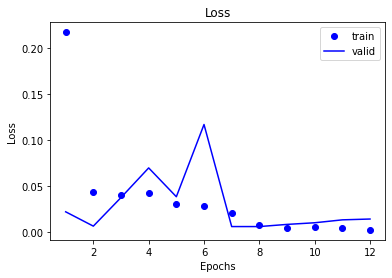

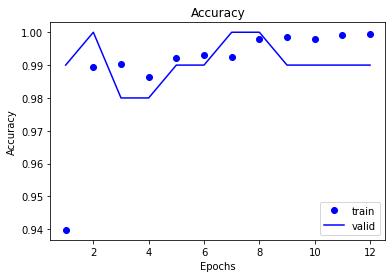

best val_acc: 1.0 epoch: 1
best val_loss: 0.005793907679617405 epoch: 6


In [6]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
acc_values = history_dict["accuracy"]
val_acc_values = history_dict["val_accuracy"]
epochs = range(1, len(history_dict["accuracy"]) + 1)

plt.plot(epochs, loss_values, "bo", label="train")
plt.plot(epochs, val_loss_values, "b", label="valid")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, acc_values, "bo", label="train")
plt.plot(epochs, val_acc_values, "b", label="valid")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

import numpy as np
print("best val_acc:", np.max(val_acc_values), "epoch:", np.argmax(val_acc_values))
print("best val_loss:", np.min(val_loss_values), "epoch:", np.argmin(val_loss_values))

# testing

In [7]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)

4/4 [==============================] - 5s 1s/step - loss: 0.0189 - accuracy: 0.9900
Test Accuracy: 0.9899999499320984


In [8]:
model.save("./models/vit_l32_finetuned.h5")

## Running Predictions From Saved Model

In [22]:
def decode (predicted_arr):
  train_path = './dataset/20train'

  all_birds_cat = np.array(list(os.listdir(train_path)))
  for i, pred in enumerate(predicted_arr):
    print(np.argmax(pred))
    return all_birds_cat[np.argmax(pred)]

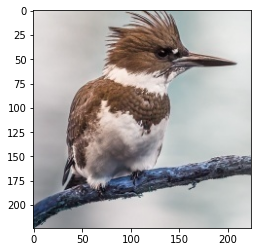

2022-05-06 19:12:46.780494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.0327522  0.06201952 0.02765414 0.00971547 0.07627753 0.14888683
  0.03773537 0.07404899 0.03723053 0.08893851 0.0505968  0.0237307
  0.01297791 0.05198682 0.01918366 0.09647261 0.01568799 0.02695537
  0.02425952 0.08288953]]
5
AMERICAN REDSTART


In [23]:
model = load_model('./models/vit_l32_finetuned.h5')

predict_image_path = './dataset/20test/BELTED KINGFISHER/1.jpg'

plt.imshow(cv2.imread(predict_image_path))
plt.show();
img = load_img(predict_image_path, target_size=(224,224))
img = img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

predictions = model.predict(img)

print(predictions)
label = decode(predictions)

print(label)